In [6]:
import re
from collections import Counter
import string
import math
import spacy
import nltk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from tqdm.auto import tqdm
import scipy as sp
import seaborn as sns
import pandas as pd
import polars as pl
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, cmudict
from nltk.corpus import words as nltk_words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

np.random.seed(42)

In [7]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/sample_submission.csv')

In [8]:
train.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [9]:
test.head()

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [10]:
submission.head()

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


# data processing

In [11]:
cList = {
  "ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because",  "could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not",
  "haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is",
  "how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I would","I'd've": "I would have","I'll": "I will","I'll've": "I will have","I'm": "I am","I've": "I have",
  "isn't": "is not","it'd": "it had","it'd've": "it would have","it'll": "it will", "it'll've": "it will have","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not",
  "might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
  "shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
  "should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there had","there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had",
  "we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
  "weren't": "were not","what'll": "what will","what'll've": "what will have",
  "what're": "what are","what's": "what is","what've": "what have","when's": "when is","when've": "when have",
  "where'd": "where did","where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is",
  "why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not",
  "wouldn't've": "would not have","y'all": "you all","y'alls": "you alls","y'all'd": "you all would",
  "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you you will","you'll've": "you you will have","you're": "you are",  "you've": "you have"
   }

In [12]:
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

def removeHTML(x):
    html = re.compile(r'<.*?>')
    return html.sub(r'',x) # html -> ''

def dataPreprocessing(x):
    
    x = x.lower()
    # remove html
    x = removeHTML(x)
    
    #remove string with starting @
    x = re.sub("@\w+",'',x)
    
    # remove number
    x = re.sub("'\d+",'',x)
    x = re.sub("\d+",'',x)
    
    # remove url
    x = re.sub("http\w+",'',x)
    
    # Replace consecutive empty spaces with a single empty spaces
    x = re.sub(r'\s+', " ", x)

    # Replace consecutive commas and periods with a single comma and period
    x = expandContractions(x)
    x = re.sub(r'\.+', ".",x)
    x = re.sub(r'\,+', ",",x)
    x = re.sub(r'[^\w\s.,;:""''?!]', '', x)
    
    # Remove empty character at the beginning and end
    x = x.strip()
    return x

In [13]:
train = pl.from_pandas(train)

train = train.with_columns(
         pl.col('full_text').map_elements(lambda x: dataPreprocessing(x))
)
train = train.to_pandas()

/var/folders/ls/65g9k4kd4_j8k3x277xdkd500000gn/T/ipykernel_58393/4137260655.py:3: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  train = train.with_columns(


In [14]:
test = pl.from_pandas(test)

test = test.with_columns(
         pl.col('full_text').map_elements(lambda x: dataPreprocessing(x))
)
test = test.to_pandas()

/var/folders/ls/65g9k4kd4_j8k3x277xdkd500000gn/T/ipykernel_58393/1235424326.py:3: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  test = test.with_columns(


In [15]:
train["full_text"][0]

'many people have car where they live. the thing they do not know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in vauban,germany they dont have that proble because percent of vaubans families do not own cars,and percent sold a car to move there. street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the french and swiss borders. you probaly will not see a car in vaubans streets because they are completely "car free" but if some that lives in vauban that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for , along with a home. the vauban people completed this in ,they said that this an example of a growing trend in europe,the untile states and some where else are suburban lif

In [16]:
test["full_text"][0]

'many people have car where they live. the thing they do not know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in vauban,germany they dont have that proble because percent of vaubans families do not own cars,and percent sold a car to move there. street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the french and swiss borders. you probaly will not see a car in vaubans streets because they are completely "car free" but if some that lives in vauban that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for , along with a home. the vauban people completed this in ,they said that this an example of a growing trend in europe,the untile states and some where else are suburban lif

In [17]:
# one example per each score 1 and 6 to see the difference
print("Score 1")
print(train[train["score"] == 1]["full_text"].values[0])
print("\nScore 6")
print(train[train["score"] == 6]["full_text"].values[0])


Score 1
the challenge of exploring venus is a informative text, venus called the evening staris one of the brightest point of light in the night sky,in the solar systen venus is the secont from our sun; earths twin venus is teh close planet to earth, and occasionally the closest in distance too earth, venus, and mars. first, venus is a hot planet, venus has somre persent of carbon dioxide,venus is so closer to the sumfor that reason venus has the hottest surface temperature of any planet in iur solar system. the temoperature is the over degrees fahrenheit, and the atmosphere presure is times greater than what we experience on our own planet, people cannot survive. secondly, the scientifict however, peering at venus from a ship orbiting or hovering safely far above the planet can povide only limited insight on ground conditions because about however the light cannot penetrate th eatmosphere and it is from photography an dvideography ineffective. lastly, the nasa is working about proyect

# features engineering

In [19]:
class TextFeatureExtractor:
    def __init__(self):
        pass
    
    def word_count(self, text):
        return len(word_tokenize(text))
    
    def sentence_count(self, text):
        return len(sent_tokenize(text))
    
    def essay_length(self, text):
        return len(text)
    
    def extract_features(self, text):
        features = {
            'word_count': self.word_count(text),
            'sentence_count': self.sentence_count(text),
            'essay_length': self.essay_length(text)
        }
        return features

In [ ]:
def apply_text_features(df, text_column):
    extractor = TextFeatureExtractor()
    for feature in ['word_count', 'sentence_count', 'essay_length']:
        df[feature] = df[text_column].apply(lambda x: getattr(extractor, feature)(x))

apply_text_features(train, 'full_text')
apply_text_features(test, 'full_text')

In [ ]:
print(train.head())
# train.to_csv('../data/train_features.csv', index=False)

In [21]:
train = pd.read_csv('../data/train_features.csv')

# explatorary data analysis

In [24]:
summary_stats = train[['word_count', 'sentence_count', 'essay_length']].describe()
print(summary_stats)

         word_count  sentence_count  essay_length
count  17307.000000    17307.000000  17307.000000
mean     404.170971       19.222222   2037.188768
std      166.653080        8.732055    860.348895
min      153.000000        1.000000    711.000000
25%      276.000000       13.000000   1378.000000
50%      377.000000       18.000000   1900.000000
75%      496.500000       24.000000   2512.000000
max     1740.000000      133.000000   8033.000000


In [25]:
train[['score', 'word_count', 'sentence_count', 'essay_length']].corr()


,score,word_count,sentence_count,essay_length
score,1.000000,0.698212,0.584264,0.706035
word_count,0.698212,1.000000,0.812793,0.991441
sentence_count,0.584264,0.812793,1.000000,0.781410
essay_length,0.706035,0.991441,0.781410,1.000000


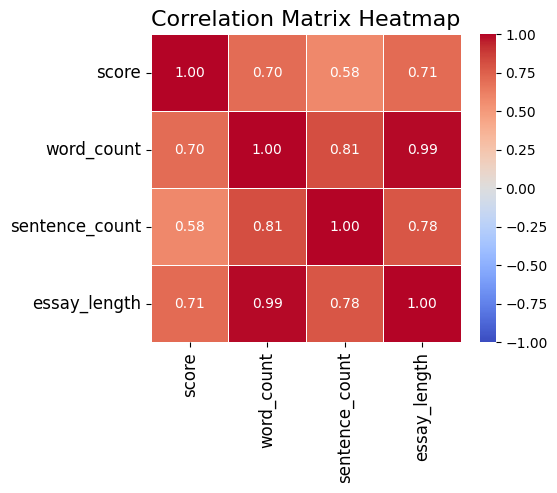

In [27]:
# Calculate the correlation matrix
corr_matrix = train[['score', 'word_count', 'sentence_count', 'essay_length']].corr()

# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5, annot_kws={"size": 10})
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

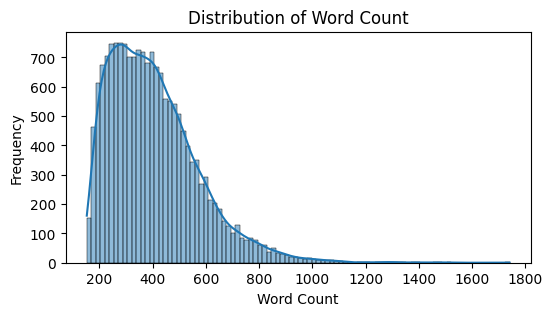

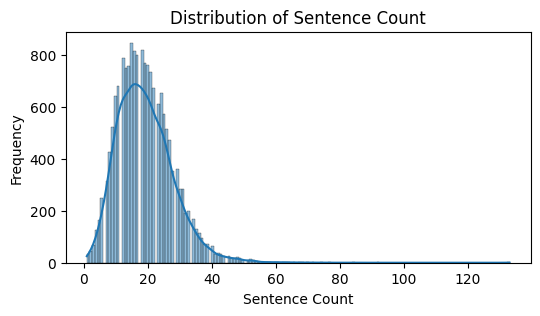

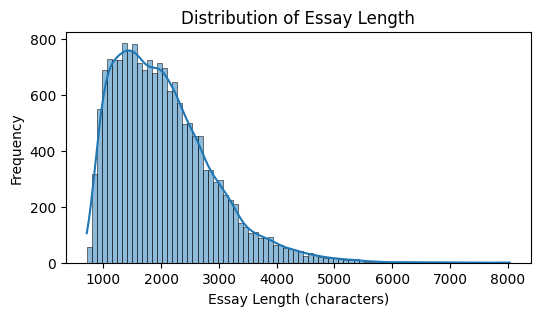

<Figure size 400x400 with 0 Axes>

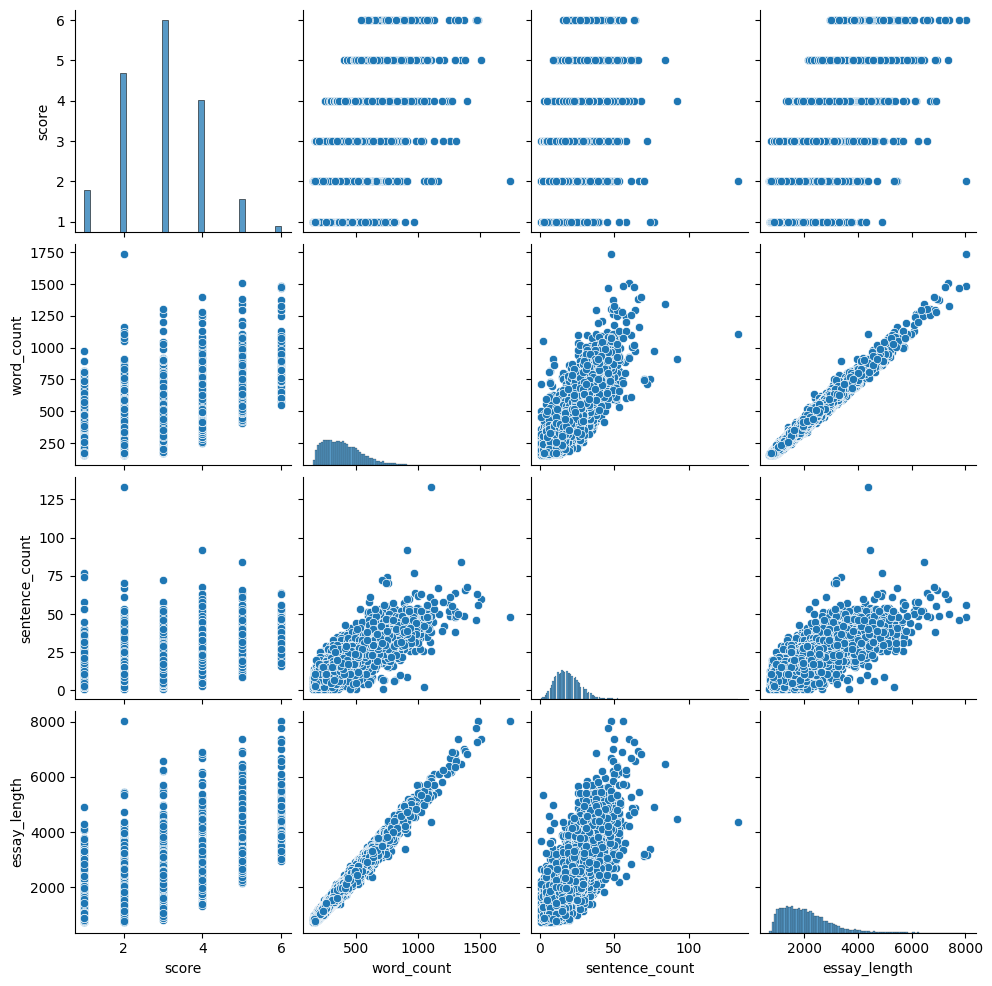

In [32]:
# Distribution of word count
plt.figure(figsize=(6, 3))
sns.histplot(train['word_count'], kde=True)
plt.title('Distribution of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Distribution of sentence count
plt.figure(figsize=(6, 3))
sns.histplot(train['sentence_count'], kde=True)
plt.title('Distribution of Sentence Count')
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.show()

# Distribution of essay length
plt.figure(figsize=(6, 3))
sns.histplot(train['essay_length'], kde=True)
plt.title('Distribution of Essay Length')
plt.xlabel('Essay Length (characters)')
plt.ylabel('Frequency')
plt.show()

# Pairplot to visualize relationships
plt.figure(figsize=(4, 4))
sns.pairplot(train[['score', 'word_count', 'sentence_count', 'essay_length']])
plt.show()